In [807]:
from biopandas.pdb import PandasPdb
from math import exp
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib import cm
from scipy import spatial
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline  

In [808]:
def centre_model(atoms):
    '''Calculate the centre of gravity and "moves" the protein so the CG is located in origo.'''
    
    CG=[atoms.x_coord.mean(),atoms.y_coord.mean(), atoms.z_coord.mean()]     
    atoms['x_coord']=atoms.x_coord.subtract(CG[0]) #subtracts CG coordinate from all coordinates
    atoms['y_coord']=atoms.y_coord.subtract(CG[1])
    atoms['z_coord']=atoms.z_coord.subtract(CG[2])
    
    
    return atoms

In [809]:
def atoms_to_map(atoms, atom_type):
    
    
    atom_types_dict={ #Type1 - Sulfur/ selenium
                    ('CYS', 'SG') : 'Type1',
                    ('MET', 'SD') : 'Type1',
                    ('MSE', 'SE') : 'Type1',
                     #Type2 - Nitrogen (amide)
                    ('ASN', 'ND2'): 'Type2',
                    ('GLN', 'NE2') : 'Type2',
                    ('N'):'Type2',  #backbone N inc N-terminal
                    #Type3 - Nitrogen (aromatic)
                    ('HIS', 'ND1') : 'Type3',
                    ('HIS', 'NE1') : 'Type3',
                    ('TRP', 'NE1') : 'Type3',
                    #Type4 - Nitrogen (guanidinium)
                    ('ARG', 'NE'): 'Type4' ,
                    ('ARG', 'NH1'): 'Type4' ,
                    ('ARG', 'NH2'): 'Type4' ,
                    ('ARG', 'NH3'): 'Type4' ,
                    #Type5 - Nitrogen (ammonium)
                    ('LYS', 'NZ'): 'Type5' ,
                    #Type6 - Oxygen (carbonyl)
                    ('ASN', 'OD1') : 'Type6' , 
                    ('GLN', 'OE1'): 'Type6' ,
                    ('O'): 'Type6', # backbone O (should be exept C terminal BUT HOW?)
                    #Type7 - oxygen (hydroxyl)
                    ('SER', 'OG'): 'Type7' ,
                    ('THR', 'OG1'): 'Type7' ,
                    ('TYR', 'OH'): 'Type7' ,
                    #Type8 - Oxygen (carboxyl)
                    ('ASP', 'OD1') : 'Type8',
                    ('ASP', 'OD2') : 'Type8',
                    ('ASP', 'OD3') : 'Type8',
                    ('GLU', 'OE1') : 'Type8', 
                    ('GLU', 'OE2') : 'Type8',
                    ('GLU', 'OE3') : 'Type8',
                    ('OXT'):'Type8', #and C-terminal O NEEDS TO BE ADDED
                    #Type9 - Carbon (sp2)
                    ('ARG', 'CZ') : 'Type9',
                    ('ASN', 'CG') : 'Type9',
                    ('ASP', 'CG') : 'Type9',
                    ('GLN', 'CD') : 'Type9',
                    ('GLU', 'CD') : 'Type9',
                    ('C'):'Type9', #and backbone C
                    #Type10 - carbon (aromatic)
                    ('HIS', 'CG') : 'Type10',
                    ('HIS', 'CD2') : 'Type10',
                    ('HIS', 'CE1') : 'Type10',
                    ('PHE', 'CG') : 'Type10',
                    ('PHE', 'CD1') : 'Type10',
                    ('PHE', 'CD2') : 'Type10',
                    ('PHE', 'CD3') : 'Type10',
                    ('PHE', 'CE1') : 'Type10',
                    ('PHE', 'CE2') : 'Type10',
                    ('PHE', 'CE3') : 'Type10',
                    ('PHE', 'CZ') : 'Type10',
                    ('TRP', 'CG') : 'Type10',
                    ('TRP', 'CD1') : 'Type10',
                    ('TRP', 'CD2') : 'Type10',
                    ('TRP', 'CD3') : 'Type10',
                    ('TRP', 'CE1') : 'Type10',
                    ('TRP', 'CE2') : 'Type10',
                    ('TRP', 'CE3') : 'Type10',
                    ('TRP', 'CZ1') : 'Type10',
                    ('TRP', 'CZ2') : 'Type10',
                    ('TRP', 'CZ3') : 'Type10',
                    ('TRP', 'CH2') : 'Type10',
                    ('TYR', 'CG') : 'Type10',
                    ('TYR', 'CD1') : 'Type10',
                    ('TYR', 'CD2') : 'Type10',
                    ('TYR', 'CD3') : 'Type10',
                    ('TYR', 'CE1') : 'Type10',
                    ('TYR', 'CE2') : 'Type10',
                    ('TYR', 'CE3') : 'Type10',
                    ('TYR', 'CZ') : 'Type10',
                    # type11
                    ('ALA', 'CB') : 'Type11',
                    ('ARG', 'CB') : 'Type11',
                    ('ARG', 'CG') : 'Type11',
                    ('ARG', 'CD') : 'Type11',
                    ('ASN', 'CB'): 'Type11' ,
                    ( 'ASP', 'CB') : 'Type11',
                    ('CYS', 'CB') : 'Type11',
                    ('GLN', 'CB') : 'Type11',
                    ('GLN', 'CG') : 'Type11',
                    ('GLU', 'CB') : 'Type11',
                    ('GLU', 'CG') : 'Type11' ,
                    ('HIS', 'CB') : 'Type11' ,
                    ('ILE' , 'CB') : 'Type11',
                    ('ILE' , 'CG1') : 'Type11',
                    ('ILE' , 'CG2') : 'Type11',
                    ('ILE' , 'CG3') : 'Type11',
                    ('ILE' , 'CD1') : 'Type11',
                    ('LEU' , 'CB') : 'Type11',
                    ('LEU' , 'CG') : 'Type11',
                    ('LEU' , 'CD1') : 'Type11',
                    ('LEU' , 'CD2') : 'Type11',
                    ('LEU' , 'CD3') : 'Type11',
                    ('LYS' , 'CB') : 'Type11',
                    ('LYS' , 'CG') : 'Type11',
                    ('LYS' , 'CD') : 'Type11',
                    ('LYS' , 'CE') : 'Type11',
                    ('MET' , 'CB') : 'Type11',
                    ('MET' , 'CG') : 'Type11',
                    ('MET' , 'CE') : 'Type11',
                    ('MSE' , 'CB') : 'Type11',
                    ('MSE' , 'CG') : 'Type11',
                    ('MSE' , 'CE') : 'Type11',
                    ('PHE' , 'CB') : 'Type11',
                    ('PRO' , 'CB') : 'Type11',
                    ('PRO' , 'CG') : 'Type11',
                    ('PRO' , 'CD') : 'Type11',
                    ('SER' , 'CB') : 'Type11',
                    ('THR' , 'CB') : 'Type11',
                    ('THR' , 'CG2') : 'Type11',
                    ('TRP' , 'CB') : 'Type11',
                    ('TYR' , 'CB') : 'Type11',
                    ('VAL' , 'CB') : 'Type11', 
                    ('VAL' , 'CG1') : 'Type11',
                    ('VAL' , 'CG2') : 'Type11',
                    ('VAL' , 'CG3') : 'Type11',
                    ('CA'): 'Type11'#and backbone CA 
                    }
    
    
    new_atoms=atoms

    for index,row in atoms.iterrows(): 
        
        if (row['residue_name'], row['atom_name']) not in atom_types_dict.keys():
            
            if (row['atom_name']) not in atom_types_dict.keys():
                print 'MISSAT EN ATOM OJ' , (row['residue_name'], row['atom_name'])
                new_atoms=new_atoms[new_atoms.index != index] #delete row 
            
            elif atom_types_dict[(row['atom_name'])] != atom_type:
                new_atoms=new_atoms[new_atoms.index != index] #delete row if not right type
   
        elif atom_types_dict[(row['residue_name'], row['atom_name'])] != atom_type:
            new_atoms=new_atoms[new_atoms.index != index] #delete row if not in atoms_types dict 

    return new_atoms


In [810]:
def create_density_map(atoms):
    
    dens_map=np.zeros((120,120,120)) #120x120x120 matrix filled w/ zeroes

    x_s=atoms.x_coord.subtract(-60) #adding 60 (subtracting -60, how to du addition???????)
    y_s= atoms.y_coord.subtract(-60)
    z_s=atoms.z_coord.subtract(-60)
    
    warning=0
    
    if x_s.max()>119 or y_s.max()>119 or z_s.max()>119 : 
        print'This protein is to big for the grid'
        warning=1
        return dens_map, warning
    
    coords=[x_s, y_s, z_s]
    coords=np.array(coords).T.tolist() #transpose the coordinate list
 
    for i in range(len(coords)):
        x=int(round(coords[i][0]))
        y=int(round(coords[i][1]))
        z=int(round(coords[i][2]))
        
        for  k in range(x-2,x+3): #need to take +3 to make it get to +2
            for l in range(y-2,y+3):
                for m in range(z-2,z+3):
                    
                    if k==x and l==y and m==z: #if xyz = klm , r=0 
                        dens_map[k][l][m]+=exp(0)
                    elif ((x-1)<= k <=(x+1)) and ((y-1)<=l<=(y+1)) and ((z-1)<=m<=(z+1)):       
                        dens_map[k][l][m]+=exp(1/2)
                    else:
                        dens_map[k][l][m]+=exp(-2)


    return dens_map, warning


In [811]:
def plot_map(dens_map):

    #convert df to list of lists
    values=[]
    for i in range(120):
        for j in range(120):
            for k in range(120):
                if dens_map[i][j][k]!=0:
                    values.append([i , j , k , dens_map[i][j][k]])

    values=np.transpose(values)
    x=values[0]
    y=values[1]
    z=values[2]
    density=values[3]
    
    cmap=cm.jet
    
    #no idea what's going on here
    den_vals=np.array(density)
    colors=cmap(density)
    
    density=np.array(density)
    colors[:,-1]=den_vals/den_vals.max()
   
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    surf = ax.scatter(x, y, z, c=colors)
    plt.show()
    
  
  

There are no atoms of Type1


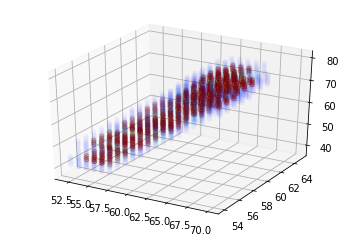

There are no atoms of Type3
There are no atoms of Type4
There are no atoms of Type5


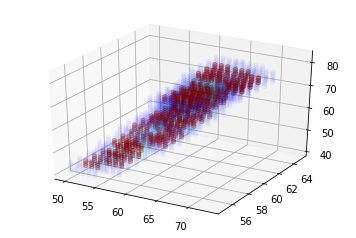

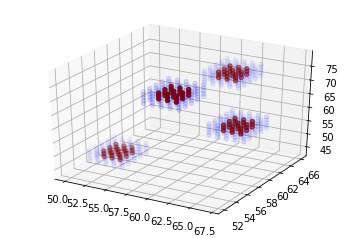

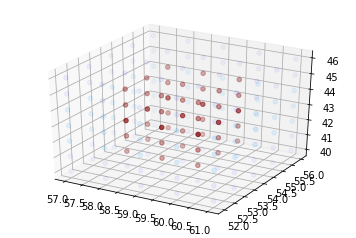

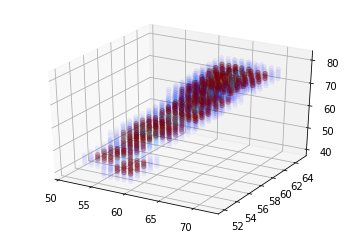

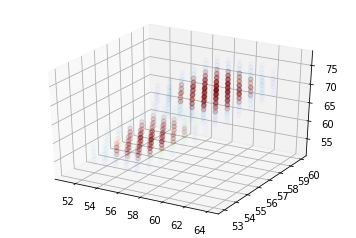

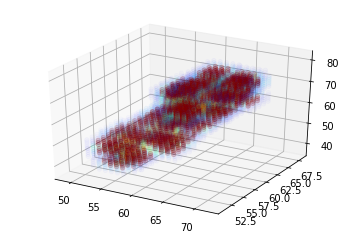

In [812]:
def main():
    ppdb=PandasPdb()
    ppdb=ppdb.read_pdb('5eh6.pdb')
    atoms=ppdb.df['ATOM']
    atoms=centre_model(atoms)
    
    atom_types=['Type1','Type2','Type3','Type4','Type5','Type6','Type7','Type8','Type9','Type10','Type11']
    
    all_density_maps={}
    for atom_type in atom_types:
        new_atoms=atoms_to_map(atoms, atom_type) # returns df only containing the atoms for choosen type
    
        density_map,warning=create_density_map(new_atoms)
        
        if warning==1: 
            print 'The protein is to big to fit inside the grid for atoms of', atom_type
        
        else:
            if np.any(density_map): # if there are atoms of chosen type (every density map that isn,t just zeroes)
                all_density_maps[atom_type]=density_map
                plot_map(density_map)
        
            else:
                print 'There are no atoms of', atom_type
            
    
   
main()
